In [5]:
import pandas as pd

df = pd.read_csv('Fraud.csv')

print("File loaded successfully! Here are the first 5 rows:")
print(df.head())

print("\nDataframe Information:")
df.info()

File loaded successfully! Here are the first 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  

Dataframe Information:
<class 'pandas.core.frame.Da

In [6]:

df.dropna(inplace=True)

print("## Fraud vs. Non-Fraud Transactions")
print(df['isFraud'].value_counts())
print("\n")

print("## Transaction Type Counts")
print(df['type'].value_counts())
print("\n")

print("## Fraud Counts by Transaction Type")

print(df.groupby('type')['isFraud'].sum())

## Fraud vs. Non-Fraud Transactions
isFraud
0.0    28212
1.0       84
Name: count, dtype: int64


## Transaction Type Counts
type
PAYMENT     13913
CASH_OUT     6108
CASH_IN      5027
TRANSFER     2735
DEBIT         513
Name: count, dtype: int64


## Fraud Counts by Transaction Type
type
CASH_IN      0.0
CASH_OUT    43.0
DEBIT        0.0
PAYMENT      0.0
TRANSFER    41.0
Name: isFraud, dtype: float64


## Visualizing Transaction Amounts for Fraud vs. Non-Fraud



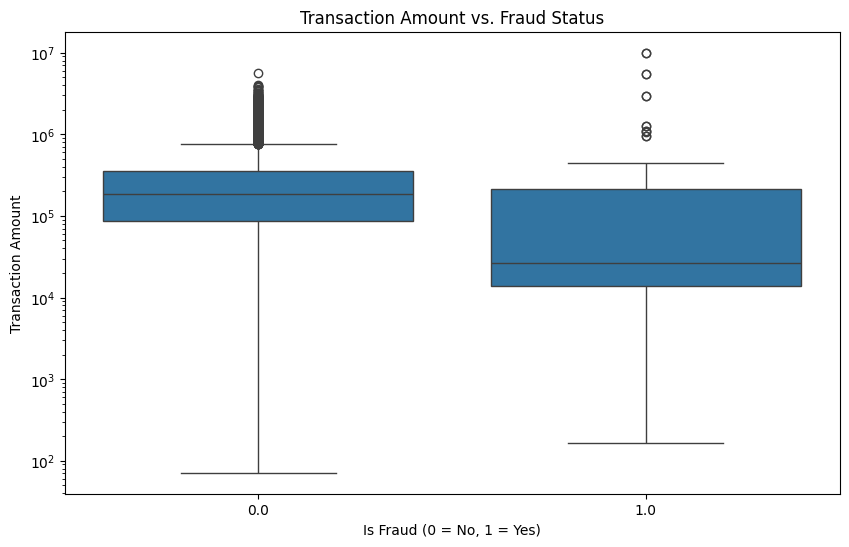


## Analyzing the 'isFlaggedFraud' System Flag

isFlaggedFraud   0.0
isFraud             
0.0             8759
1.0               84


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will only focus on the transaction types where fraud occurs
df_relevant = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]

# ---

# 1. Visualize Transaction Amounts
print("## Visualizing Transaction Amounts for Fraud vs. Non-Fraud\n")

# Create a boxplot to compare distributions
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df_relevant)
plt.title('Transaction Amount vs. Fraud Status')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Transaction Amount')

# Using a logarithmic scale can help see distributions more clearly if amounts are skewed
plt.yscale('log')
plt.show()

# ---

# 2. Analyze the 'isFlaggedFraud' feature
print("\n## Analyzing the 'isFlaggedFraud' System Flag\n")

# This shows us how many transactions were flagged vs. actually fraudulent.
flagged_vs_actual_fraud = pd.crosstab(df_relevant['isFraud'], df_relevant['isFlaggedFraud'])
print(flagged_vs_actual_fraud)

In [8]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


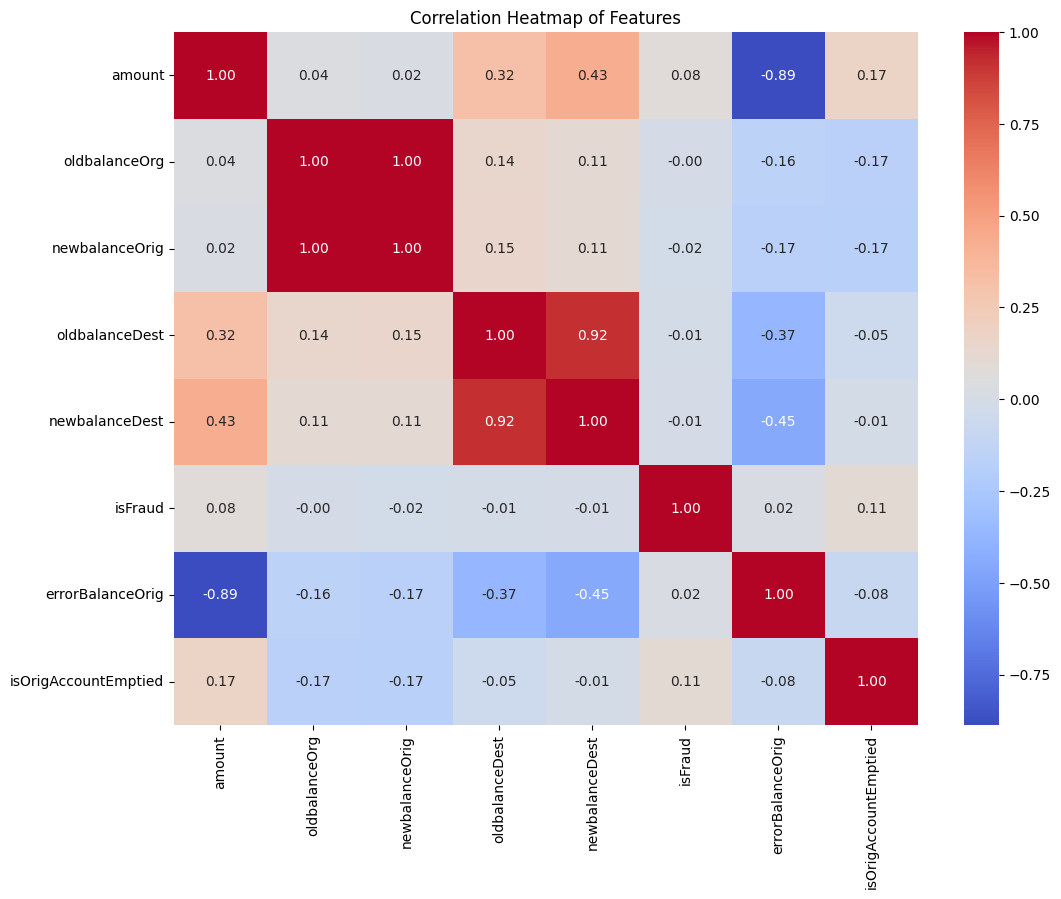

In [9]:
# adds our custom columns to the DataFrame.
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['isOrigAccountEmptied'] = (df['oldbalanceOrg'] > 0) & (df['newbalanceOrig'] == 0)


# Now, creating the heatmap using those new features ---
import matplotlib.pyplot as plt
import seaborn as sns

# Listing of all features we want to check for correlation
features_to_check = [
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'isFraud',
    'errorBalanceOrig',
    'isOrigAccountEmptied'  ]

# Calculate the correlation matrix
correlation_matrix = df[features_to_check].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Drop the columns as decided to reduce multicollinearity and remove identifiers
df_final = df.drop(columns=['newbalanceOrig', 'newbalanceDest', 'errorBalanceOrig', 'nameOrig', 'nameDest'])

# Separate features (X) from the target (y)
X = df_final.drop(columns=['isFraud'])
y = df_final['isFraud']

# Convert the categorical 'type' column into numerical format
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data preparation complete!")
print("Shape of our training features (X_train):", X_train.shape)
print("Shape of our testing features (X_test):", X_test.shape)

Data preparation complete!
Shape of our training features (X_train): (22636, 10)
Shape of our testing features (X_test): (5660, 10)


--- Training the Final XGBoost Model ---
Training complete!

--- Final Performance Report ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9985865724381625
ROC AUC Score: 0.9985614660537261
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5643
         1.0       0.80      0.71      0.75        17

    accuracy                           1.00      5660
   macro avg       0.90      0.85      0.87      5660
weighted avg       1.00      1.00      1.00      5660



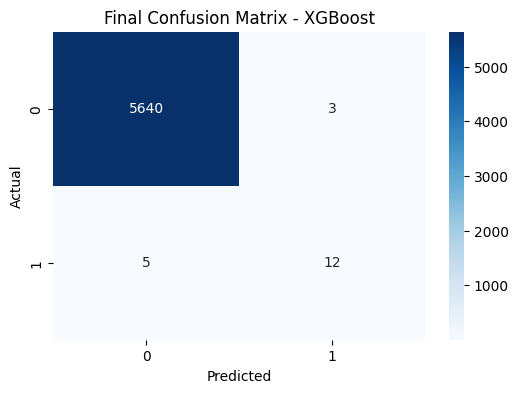

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

print("---Training the Final XGBoost Model ---")

counter = Counter(y_train)
scale_pos_weight_value = counter[0] / (counter[1] + 1e-6)

# Create an instance of the model with the best parameters
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value
)

xgb_model.fit(X_train, y_train)
print("Training complete!")
print("\n--- Final Performance Report ---")

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot of the final confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Final Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

--- SHAP Summary Plot: Overall Feature Importance ---


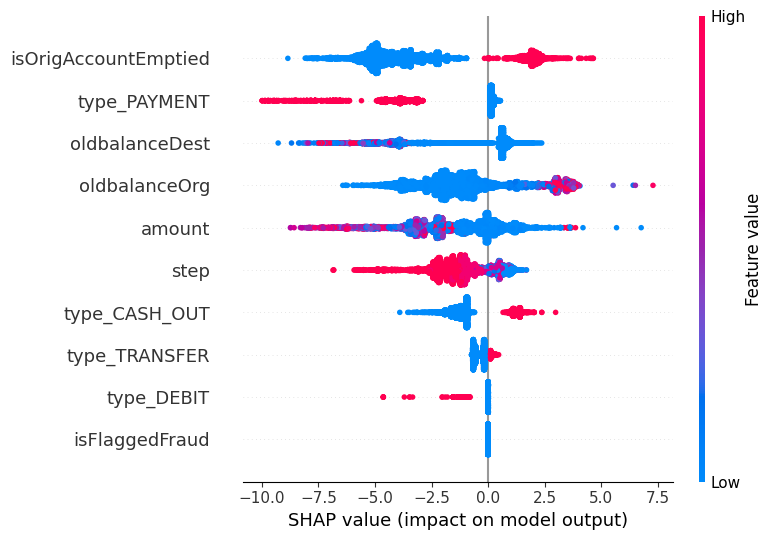


--- SHAP Force Plot: Explaining a Single Fraudulent Transaction (Index: 5123) ---


In [19]:
!pip install shap

import shap
# a SHAP explainer object for our trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# SHAP values for the test data
shap_values = explainer.shap_values(X_test)

print("--- SHAP Summary Plot: Overall Feature Importance ---")
shap.summary_plot(shap_values, X_test)
shap.initjs()

# Find a fraudulent transaction in our test set to explain
fraud_index = y_test[y_test == 1].index[0]

print(f"\n--- SHAP Force Plot: Explaining a Single Fraudulent Transaction (Index: {fraud_index}) ---")
shap.force_plot(explainer.expected_value, shap_values[fraud_index,:], X_test.loc[fraud_index,:])

In [20]:
import shap

# This line loads the necessary Javascript for the plot
shap.initjs()

# Find a fraudulent transaction to explain
fraud_index = y_test[y_test == 1].index[0]

# Now, create the force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[fraud_index,:],
    X_test.loc[fraud_index,:]
)